In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVR
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import plotly.express as px
from xgboost import XGBRegressor

set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93928/646339800.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/g4din/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93928/646339800.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inlin

In [2]:
# Load datasets
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

# Add an identifier column for each dataframe
allsvenskan['league'] = 'allsvenskan'
damallsvenskan['league'] = 'damallsvenskan'

# if event == assist, rename it to pass succesful
allsvenskan['event'] = allsvenskan['event'].replace('assist', 'pass succesful')

# Concatenate the two datasets
both = pd.concat([allsvenskan, damallsvenskan])

In [4]:
# Create a column to identify if the next action is a goal
both['is_next_goal'] = (both['action'].shift(-1) == 'Goal').astype(int)

# Identify shots and whether they resulted in a goal
both['is_shot'] = (both['action'] == 'Shot').astype(int)
shots = both[both['is_shot'] == 1]

# Scale coordinates
scale_x = lambda x: x * 120 / 100
scale_y = lambda y: y * 80 / 100
shots['x'] = shots['xpos'].apply(scale_x)
shots['y'] = shots['ypos'].apply(scale_y)

# Convert 'is_next_goal' to boolean and select relevant columns
shots['goal'] = shots['is_next_goal'].astype(bool)
shots = shots[['x', 'y', 'goal', 'league', 'header', 'penalty']]

# Apply angle and distance calculations
def calculate_angle(x, y):
    width = 7.32
    new_x = 120 - x
    new_y = abs(y - 40)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    theta = np.arctan(tan_theta) * (180 / np.pi)  # Convert radians to degrees
    return theta

def calculate_dist(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

shots['angle'] = shots.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
shots['distance'] = shots.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)

# Split the data based on league
allsvenskan_shots = shots[shots['league'] == 'allsvenskan']
damallsvenskan_shots = shots[shots['league'] == 'damallsvenskan']

# Prepare the features and labels
X_allsvenskan = allsvenskan_shots[['distance', 'angle', 'header', 'penalty']]
y_allsvenskan = allsvenskan_shots['goal'].astype(int)

X_damallsvenskan = damallsvenskan_shots[['distance', 'angle', 'header', 'penalty']]
y_damallsvenskan = damallsvenskan_shots['goal'].astype(int)

# Print the datafram containing the distance, angle, header and penalty columns
X_allsvenskan.head(50)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93928/3083129215.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = shots['xpos'].apply(scale_x)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93928/3083129215.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['y'] = shots['ypos'].apply(scale_y)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_93928/3083129215.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,distance,angle,header,penalty
74,18.646179,13.305603,False,False
106,17.366635,12.043411,False,False
114,23.637259,16.169050,False,False
163,6.053098,62.110234,True,False
269,27.888349,14.805480,False,False
337,17.366635,12.043411,False,False
353,4.326662,78.577219,True,False
428,15.388307,13.274114,False,False
453,15.681837,26.155509,False,False
483,13.440238,25.299982,False,False


In [49]:
# Now, depending on your choice, you can set the training and test sets as follows:
# For training with allsvenskan and testing with damallsvenskan
X_train, y_train = X_allsvenskan, y_allsvenskan
X_test, y_test = X_damallsvenskan, y_damallsvenskan

# Alternatively, for training with damallsvenskan and testing with damallsvenskan
#X_train, y_train = X_damallsvenskan, y_damallsvenskan
#X_test, y_test = X_allsvenskan, y_allsvenskan

## Support Vector Machine

In [50]:
# Initialize the SVR model with a pipeline
svm_model = make_pipeline(StandardScaler(), SVR())

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_svm = -cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_svm}')

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model using regression metrics
mae_svm = mean_absolute_error(y_test, y_pred)
mse_svm = mean_squared_error(y_test, y_pred)
rmse_svm = np.sqrt(mse_svm)  # Calculating RMSE
r2_svm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_svm}')
print(f'Mean Squared Error (MSE): {mse_svm}')
print(f'Root Mean Squared Error (RMSE): {rmse_svm}')
print(f'R-squared (R²): {r2_svm}')

Cross-Validated Mean Squared Error: 0.0932236641006843
Mean Absolute Error (MAE): 0.17587255667311463
Mean Squared Error (MSE): 0.08501733266833283
Root Mean Squared Error (RMSE): 0.2915773185080294
R-squared (R²): 0.08971943375364833


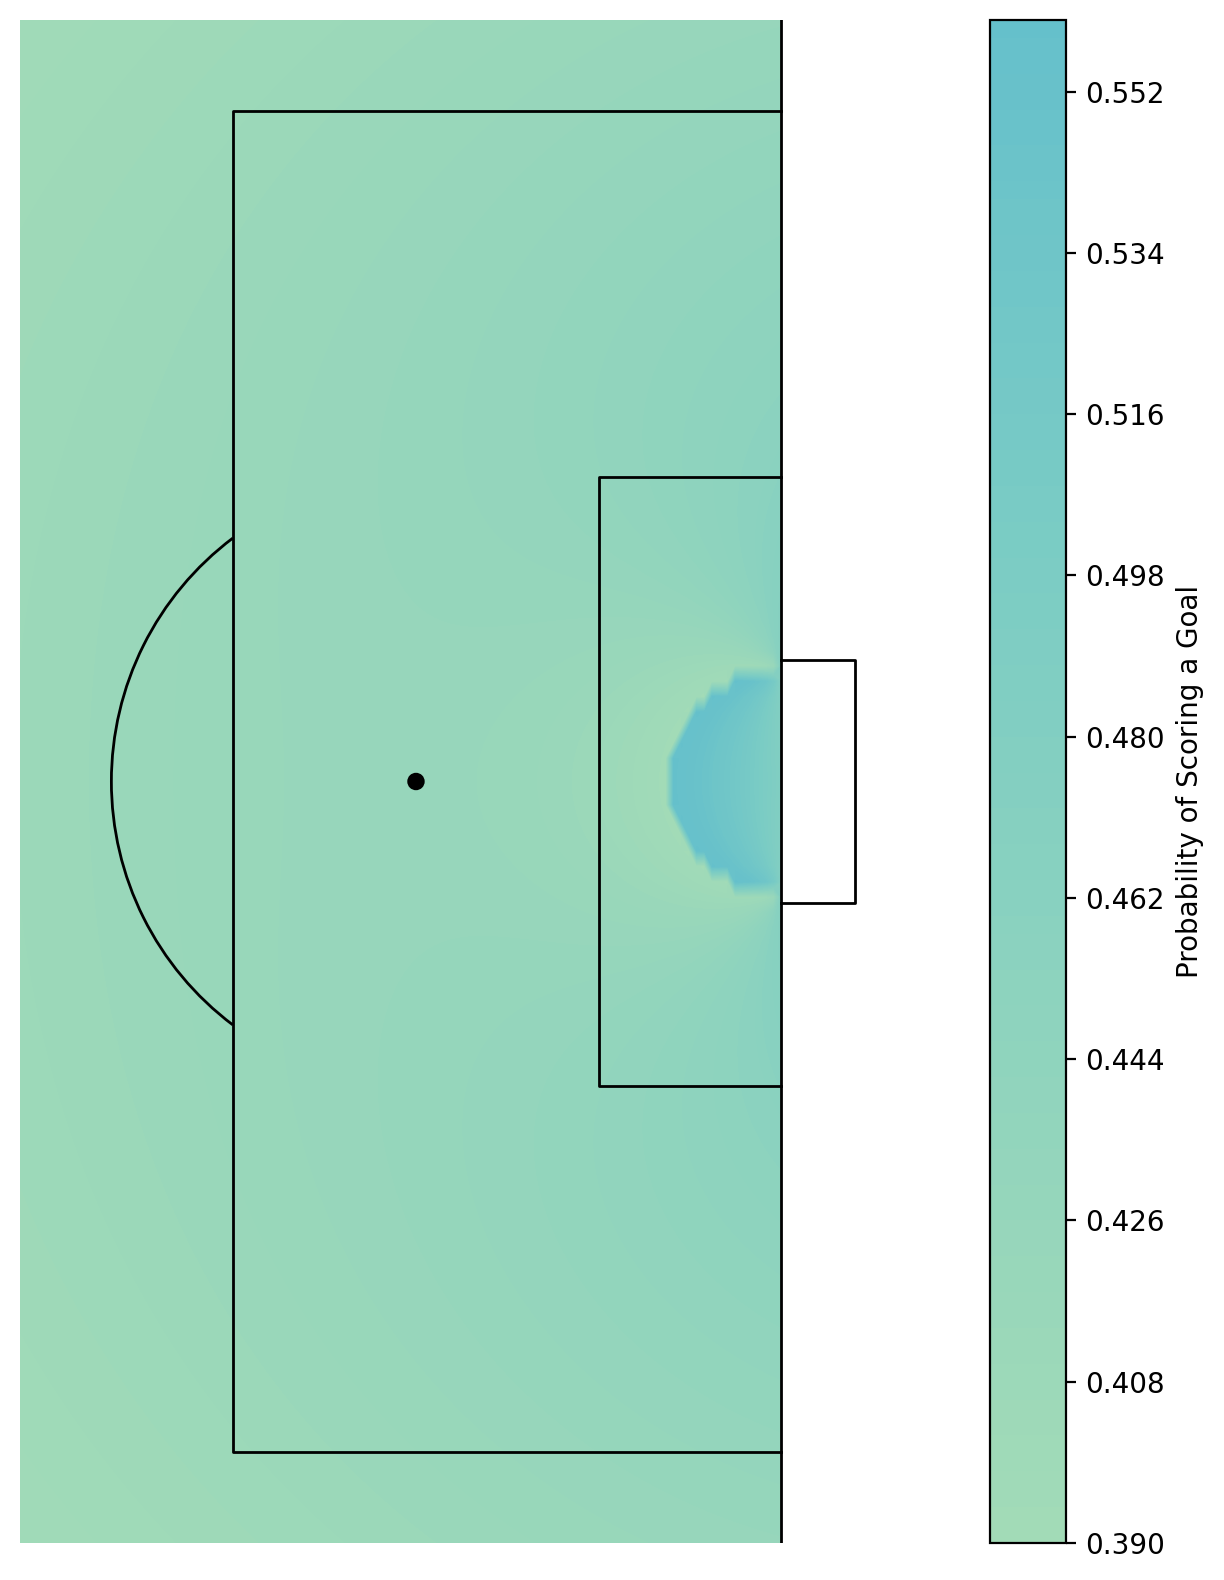

In [51]:
# Adjusted grid for higher resolution
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution
xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Assuming header is binary, let's add header = 0 for non-header attempts
# Update this line to create a full feature set including the header
# For simplicity, this example assumes all attempts are non-header. Adjust if needed.
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])  # Assuming header=0

# Scale the features as before and predict goal probabilities
scaled_full_grid_points = svm_model.named_steps['standardscaler'].transform(full_grid_points)  # Use fitted scaler
goal_predictions = svm_model.predict(scaled_full_grid_points)  # Regression predictions

# Reshape for plotting
goal_pred_matrix = goal_predictions.reshape(xx.shape)

# Plotting with increased resolution
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Set vmin and vmax for color scale
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')

# Zoom in to the penalty area
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')

plt.show()

## Decision Tree 

In [52]:
# Initialize the Decision Tree model
tree_model = DecisionTreeRegressor(max_depth=5)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_mse_dt = -cross_val_score(tree_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_dt}')

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Predictions
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred)
mae_dt = mean_absolute_error(y_test, y_pred)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_dt}')
print(f'Mean Squared Error (MSE): {mse_dt}')
print(f'Root Mean Squared Error (RMSE): {rmse_dt}')
print(f'R-squared (R²): {r2_dt}')

Cross-Validated Mean Squared Error: 0.08706780946325128
Mean Absolute Error (MAE): 0.15901442705188604
Mean Squared Error (MSE): 0.07874648177341023
Root Mean Squared Error (RMSE): 0.28061803536731245
R-squared (R²): 0.15686143320622326


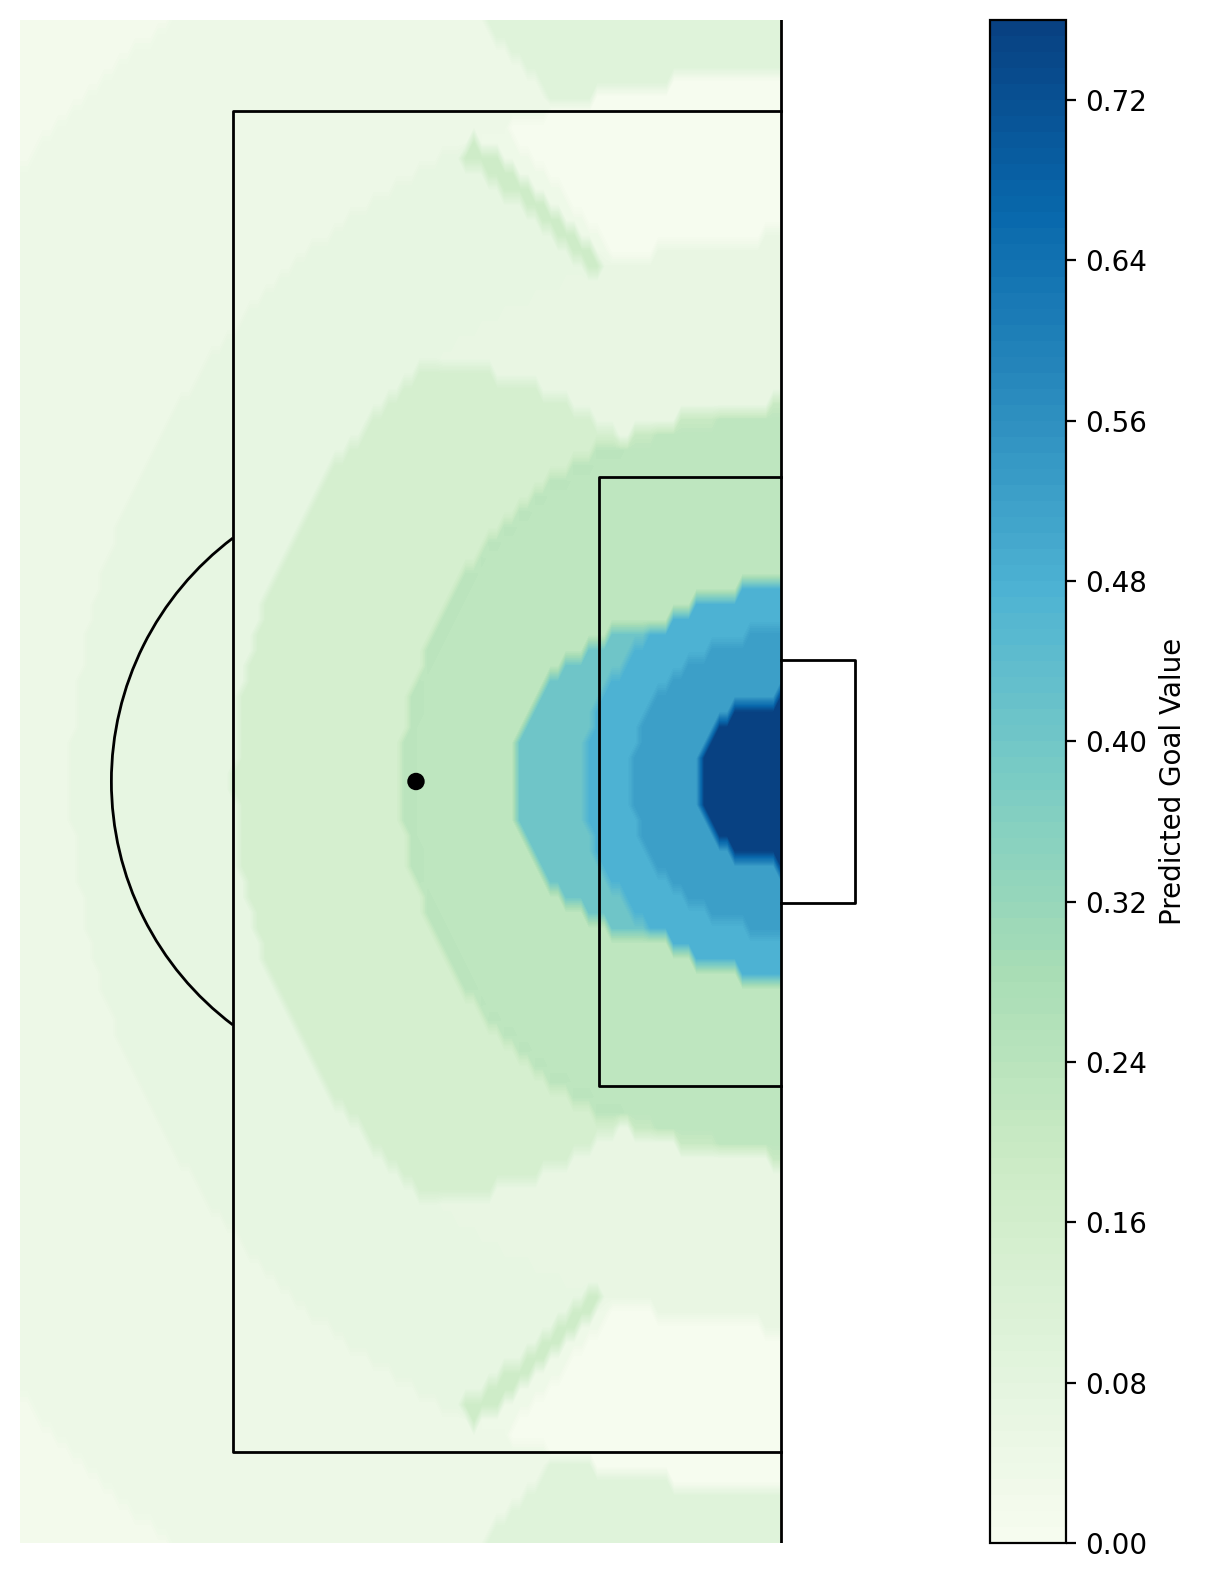

In [53]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = tree_model.predict(full_grid_points)
goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Predicted Goal Value')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Random Forest

In [54]:
forest_model = RandomForestRegressor(n_estimators=100, max_depth=5)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_rm = -cross_val_score(forest_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_rm}')

# Fit the model on the training data
forest_model.fit(X_train, y_train)

# Predictions
y_pred = forest_model.predict(X_test)

# Evaluate the model using regression metrics
mae_rm = mean_absolute_error(y_test, y_pred)
mse_rm = mean_squared_error(y_test, y_pred)
rmse_rm = np.sqrt(mse_rm)  # Calculating RMSE
r2_rm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_rm}')
print(f'Mean Squared Error (MSE): {mse_rm}')
print(f'Root Mean Squared Error (RMSE): {rmse_rm}')
print(f'R-squared (R²): {r2_rm}')

Cross-Validated Mean Squared Error: 0.08626975873549328
Mean Absolute Error (MAE): 0.15908085441252376
Mean Squared Error (MSE): 0.07818807438865838
Root Mean Squared Error (RMSE): 0.2796213053196383
R-squared (R²): 0.1628403009786462


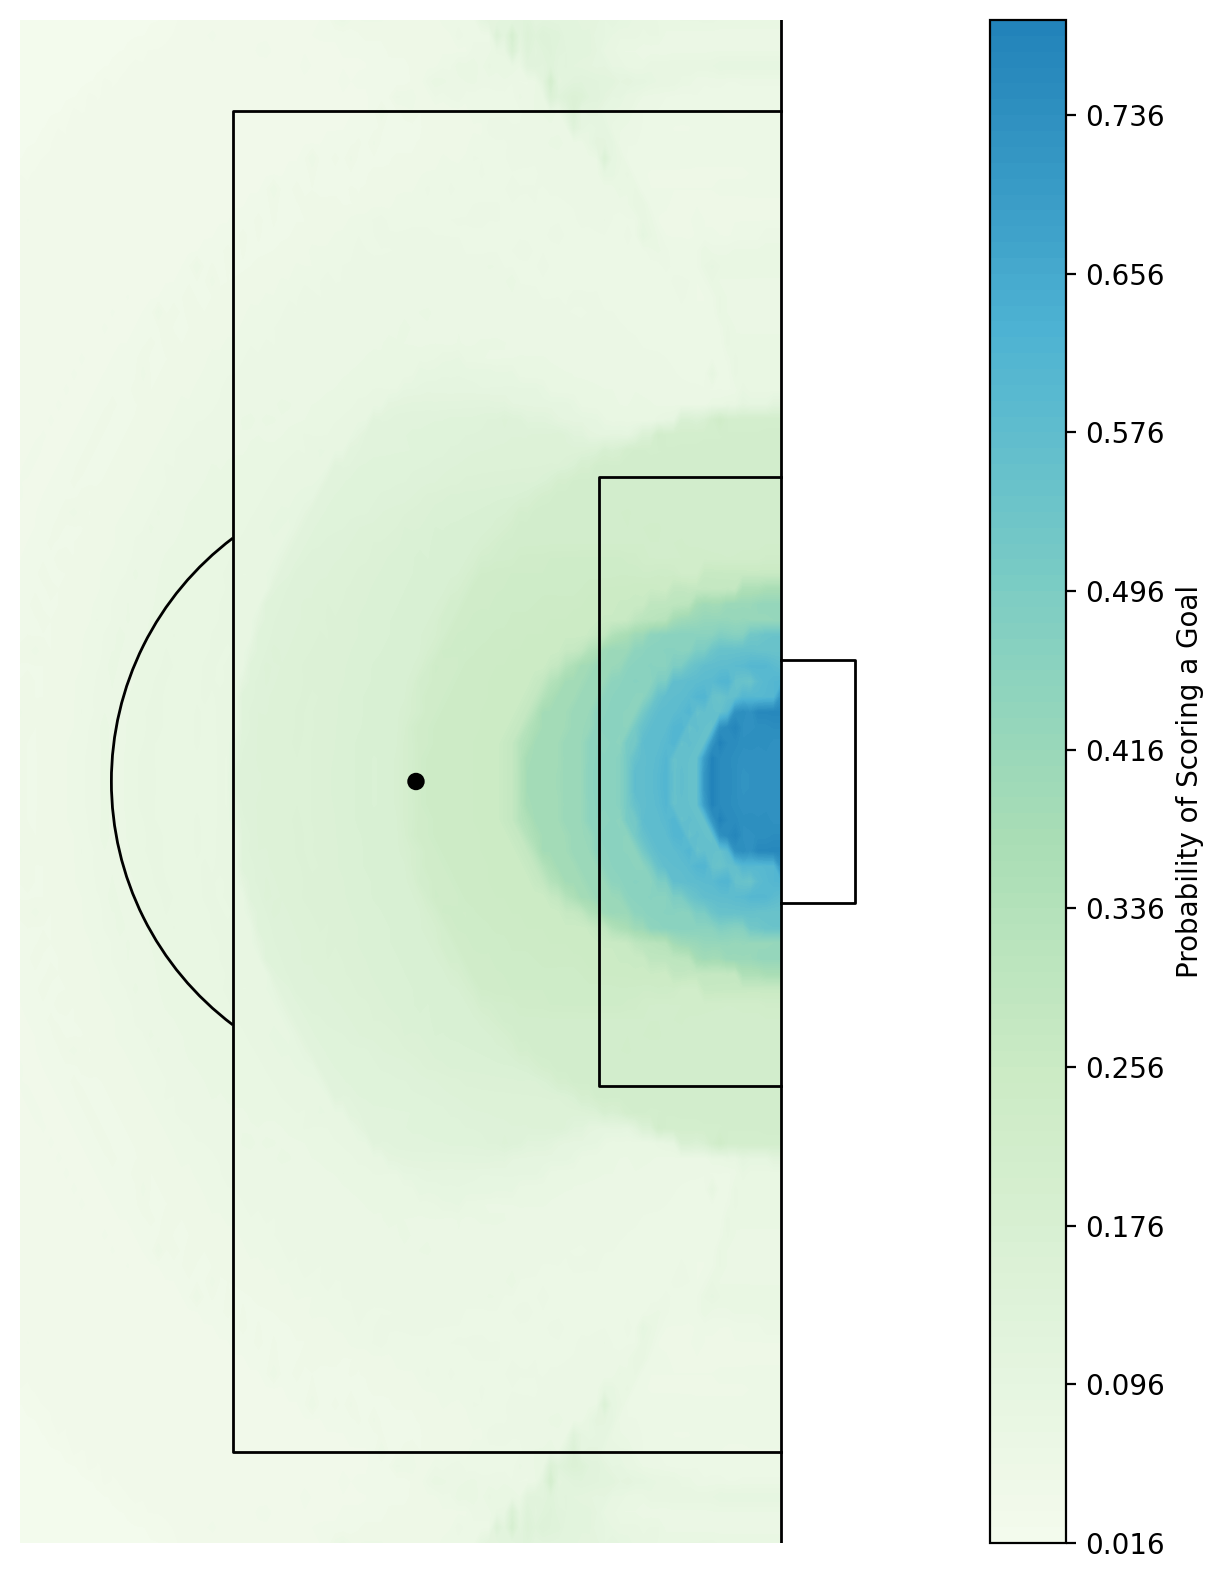

In [55]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = forest_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Neural Network

In [56]:
# Initialize the Neural Network model for regression
nn_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Note: Cross-validating neural networks can be computationally expensive, so adjust n_splits accordingly

# Cross-validation across the entire dataset for MSE estimation
cv_mse_nn = -cross_val_score(nn_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_nn}')

# Fit the model on the training data
nn_model.fit(X_train, y_train)

# Predictions
y_pred = nn_model.predict(X_test)

# Evaluate the model using regression metrics
mae_nn = mean_absolute_error(y_test, y_pred)
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)  # Calculating RMSE
r2_nn = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_nn}')
print(f'Mean Squared Error (MSE): {mse_nn}')
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')
print(f'R-squared (R²): {r2_nn}')

Cross-Validated Mean Squared Error: 0.09132489536379455
Mean Absolute Error (MAE): 0.1577079651214046
Mean Squared Error (MSE): 0.08122180474389055
Root Mean Squared Error (RMSE): 0.28499439423239636
R-squared (R²): 0.130358150587352


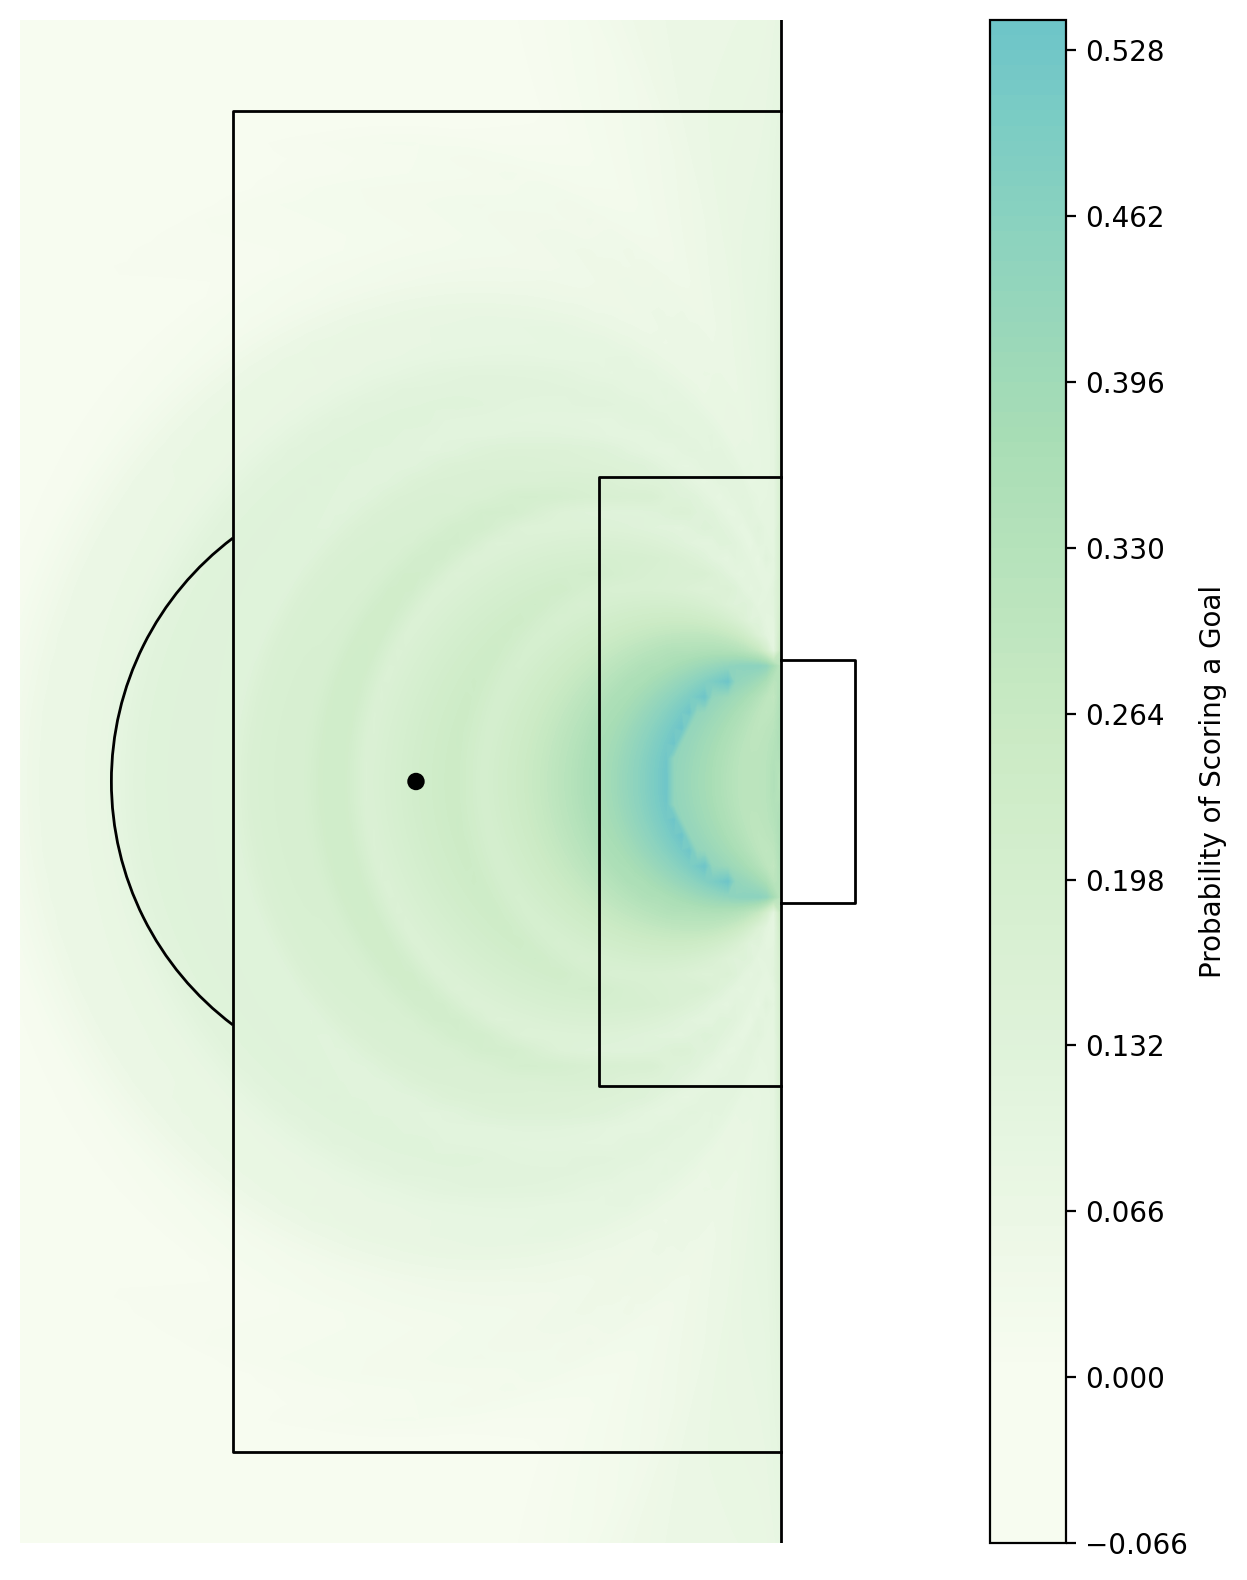

In [57]:
# Plot 
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = nn_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Logistic Regression

In [58]:
# Initialize the Logistic Regression model
log_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed for convergence

# Use K-Fold for cross-validation, more suitable for regression-like evaluation
cv = KFold(n_splits=5)

# Note: While logistic regression is typically used for classification, here we are interested in the predicted probabilities as continuous outcomes.
# Cross-validation to estimate model performance; we use 'neg_mean_squared_error' to stay consistent with regression evaluation
cv_neg_mse_log = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
cv_mse_log = -cv_neg_mse_log  # Convert to positive value
print(f'Cross-Validated Mean Squared Error: {cv_mse_log}')

# Fit the model on the training data
log_model.fit(X_train, y_train)

# Predictions - get probabilities for the positive class
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluate the model using regression metrics for the predicted probabilities
mae_log = mean_absolute_error(y_test, y_pred_proba)
mse_log = mean_squared_error(y_test, y_pred_proba)
rmse_log = np.sqrt(mse_log)  # Calculating RMSE
r2_log = r2_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_log}')
print(f'Mean Squared Error (MSE): {mse_log}')
print(f'Root Mean Squared Error (RMSE): {rmse_log}')
print(f'R-squared (R²): {r2_log}')

Cross-Validated Mean Squared Error: 0.10780822286879907
Mean Absolute Error (MAE): 0.16283212685672765
Mean Squared Error (MSE): 0.07926671499315706
Root Mean Squared Error (RMSE): 0.2815434513412753
R-squared (R²): 0.1512912962119385


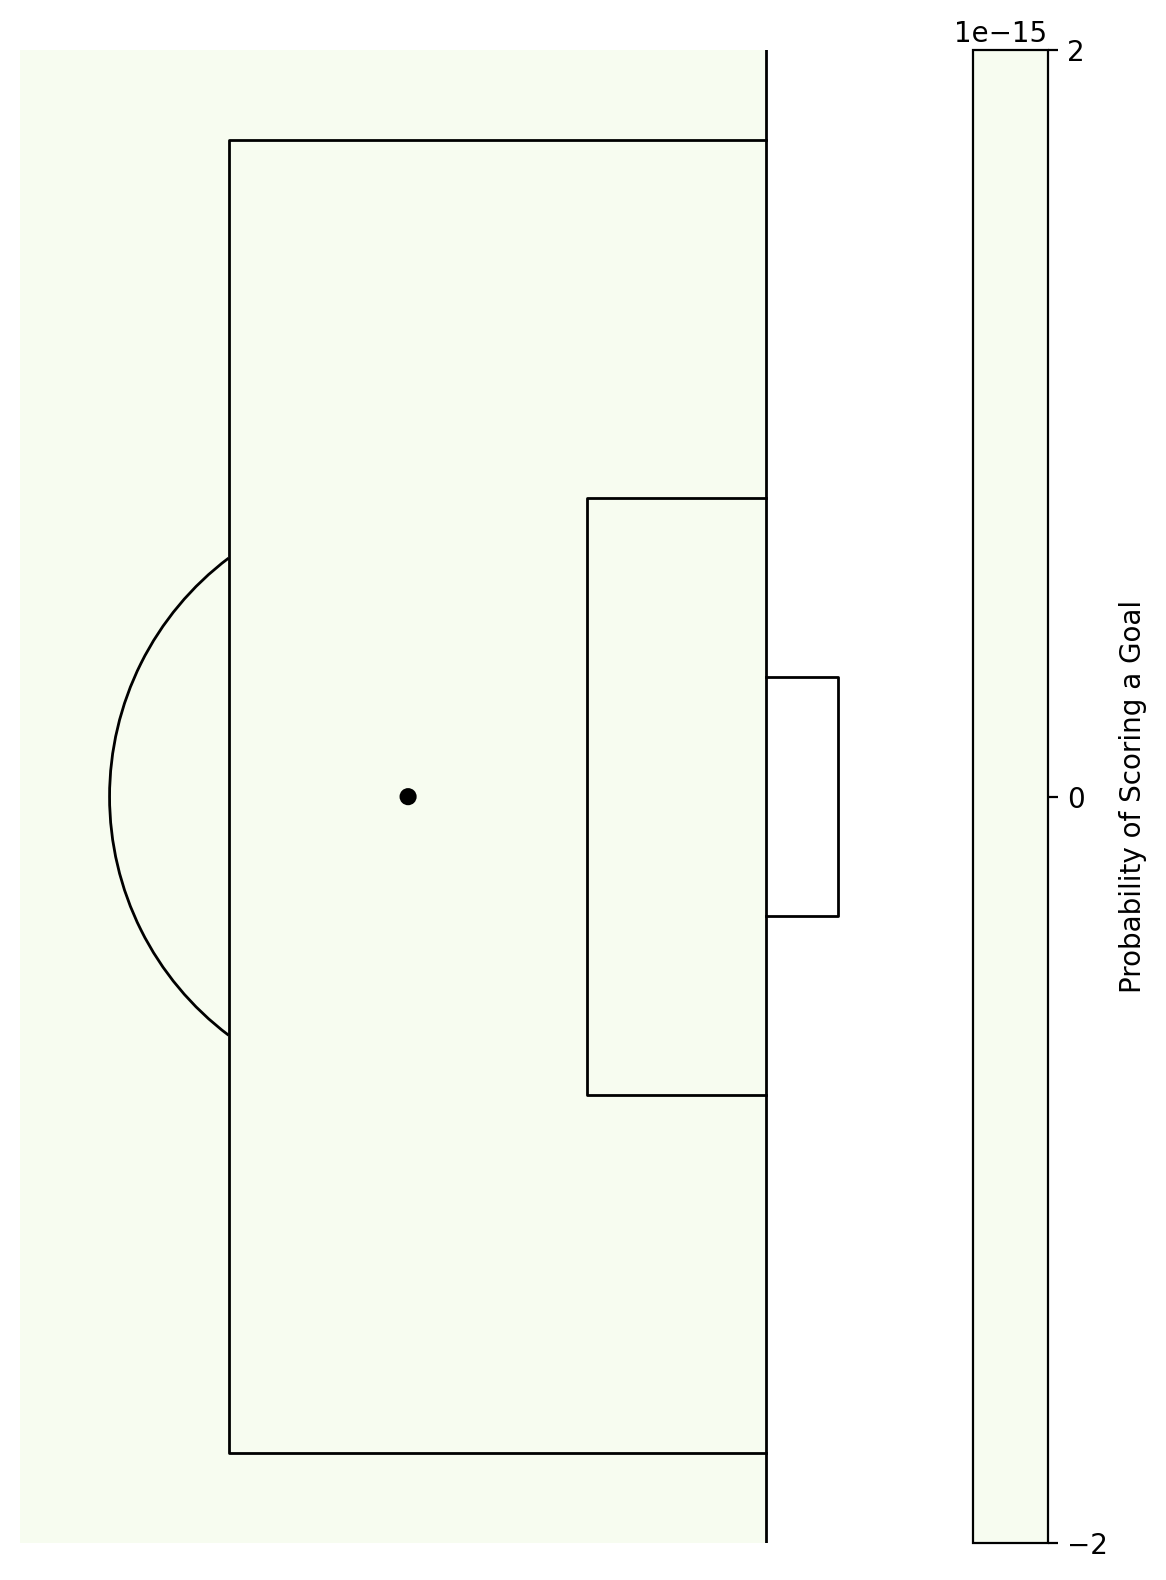

In [59]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = log_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Linear Regression

In [60]:
linear_model = make_pipeline(PolynomialFeatures(2), BayesianRidge())
linear_model.fit(X_train, y_train)

# Use KFold for regression tasks
cv = StratifiedKFold(n_splits=5)

# Use an appropriate scoring metric for regression, e.g., 'neg_mean_squared_error'
cv_score_lin = cross_val_score(linear_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
# Convert back to positive mean squared error for interpretability
cv_score_lin = -cv_score_lin
print(f'Cross-Validated Mean Squared Error: {cv_score_lin}')

# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)  # Calculating RMSE
r2_linear = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_linear}')
print(f'Mean Squared Error (MSE): {mse_linear}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear}')
print(f'R-squared (R²): {r2_linear}')

Cross-Validated Mean Squared Error: 0.0865308483791932
Mean Absolute Error (MAE): 0.1602326401135162
Mean Squared Error (MSE): 0.07859311950627199
Root Mean Squared Error (RMSE): 0.28034464415478316
R-squared (R²): 0.15850348297407524


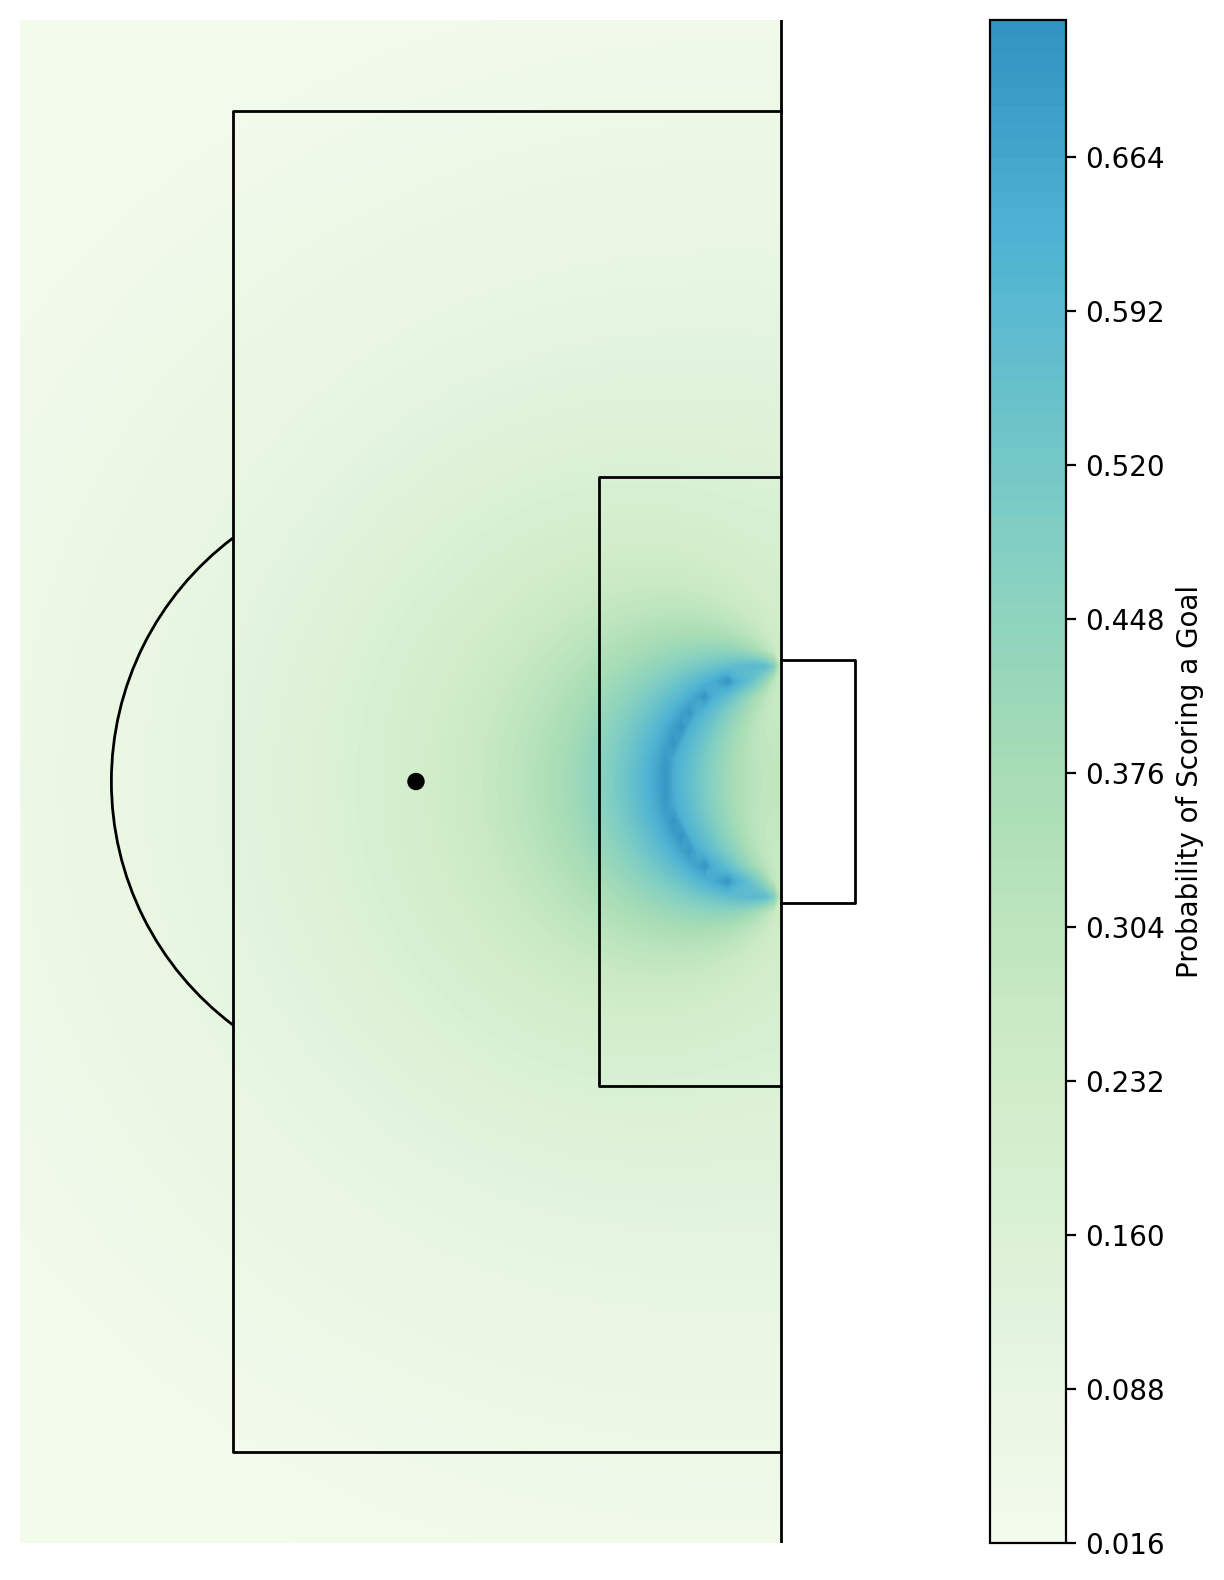

In [61]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = linear_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## XGBoost

In [62]:
# Initialize the XGBoost model for regression
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='logloss')

# Use K-Fold for cross-validation, appropriate for regression tasks
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for a general performance estimation using MSE
cv_mse_xgb = -cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_xgb}')

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using regression metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)  # Calculating RMSE
r2_xgb = r2_score(y_test, y_pred)

# Print the evaluation metrics for regression
print(f'Mean Absolute Error (MAE): {mae_xgb}')
print(f'Mean Squared Error (MSE): {mse_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb}')
print(f'R-squared (R²): {r2_xgb}')

Cross-Validated Mean Squared Error: 0.0907092739219689
Mean Absolute Error (MAE): 0.15823064753881833
Mean Squared Error (MSE): 0.08079666747482447
Root Mean Squared Error (RMSE): 0.2842475461192664
R-squared (R²): 0.1349100952540664


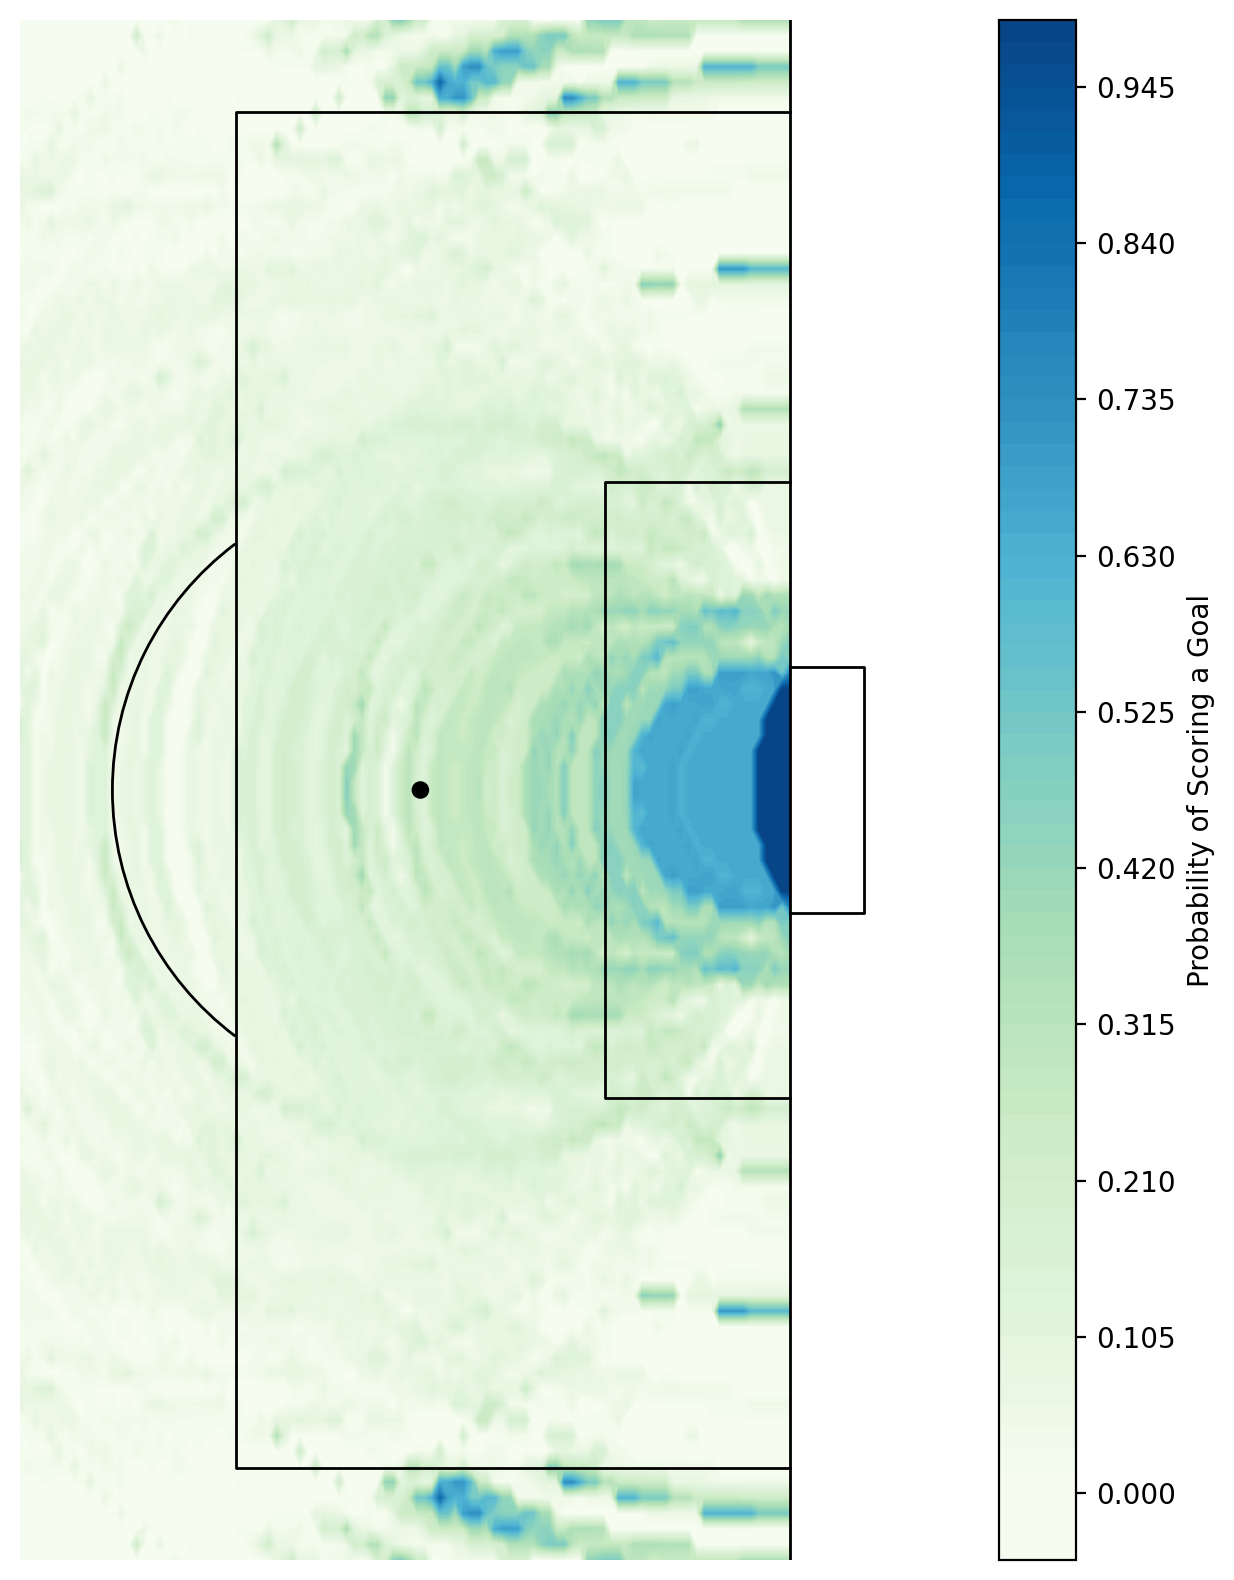

In [63]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = xgb_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
#plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Comparing Model Performance

In [64]:
# Data for regression models
types_of_models = ['Support Vector Regression', 'Decision Tree', 'Random Forest', 'Neural Network', 'Logistic Regression', 'Bayesian Ridge', 'XGBoost']
cv_mse_values = [cv_mse_svm, cv_mse_dt, cv_mse_rm, cv_mse_nn, cv_mse_log, cv_score_lin, cv_mse_xgb]
mae_values = [mae_svm, mae_dt, mae_rm, mae_nn, mae_log, mae_linear, mae_xgb]
mse_values = [mse_svm, mse_dt, mse_rm, mse_nn, mse_log, mse_linear, mse_xgb]
rmse_values = [rmse_svm, rmse_dt, rmse_rm, rmse_nn, rmse_log, rmse_linear, rmse_xgb]
r2_values = [r2_svm, r2_dt, r2_rm, r2_nn, r2_log, r2_linear, r2_xgb]

df = pd.DataFrame({'Model': types_of_models, 'Cross-Validated MSE': cv_mse_values, 'MAE': mae_values, 'MSE': mse_values, 'RMSE': rmse_values, 'R²': r2_values})
df = df.sort_values(by='Cross-Validated MSE', ascending=False)
df

,Model,Cross-Validated MSE,MAE,MSE,RMSE,R²
4,Logistic Regression,0.107808,0.162832,0.079267,0.281543,0.151291
0,Support Vector Regression,0.093224,0.175873,0.085017,0.291577,0.089719
3,Neural Network,0.091325,0.157708,0.081222,0.284994,0.130358
6,XGBoost,0.090709,0.158231,0.080797,0.284248,0.134910
1,Decision Tree,0.087068,0.159014,0.078746,0.280618,0.156861
5,Bayesian Ridge,0.086531,0.160233,0.078593,0.280345,0.158503
2,Random Forest,0.086270,0.159081,0.078188,0.279621,0.162840


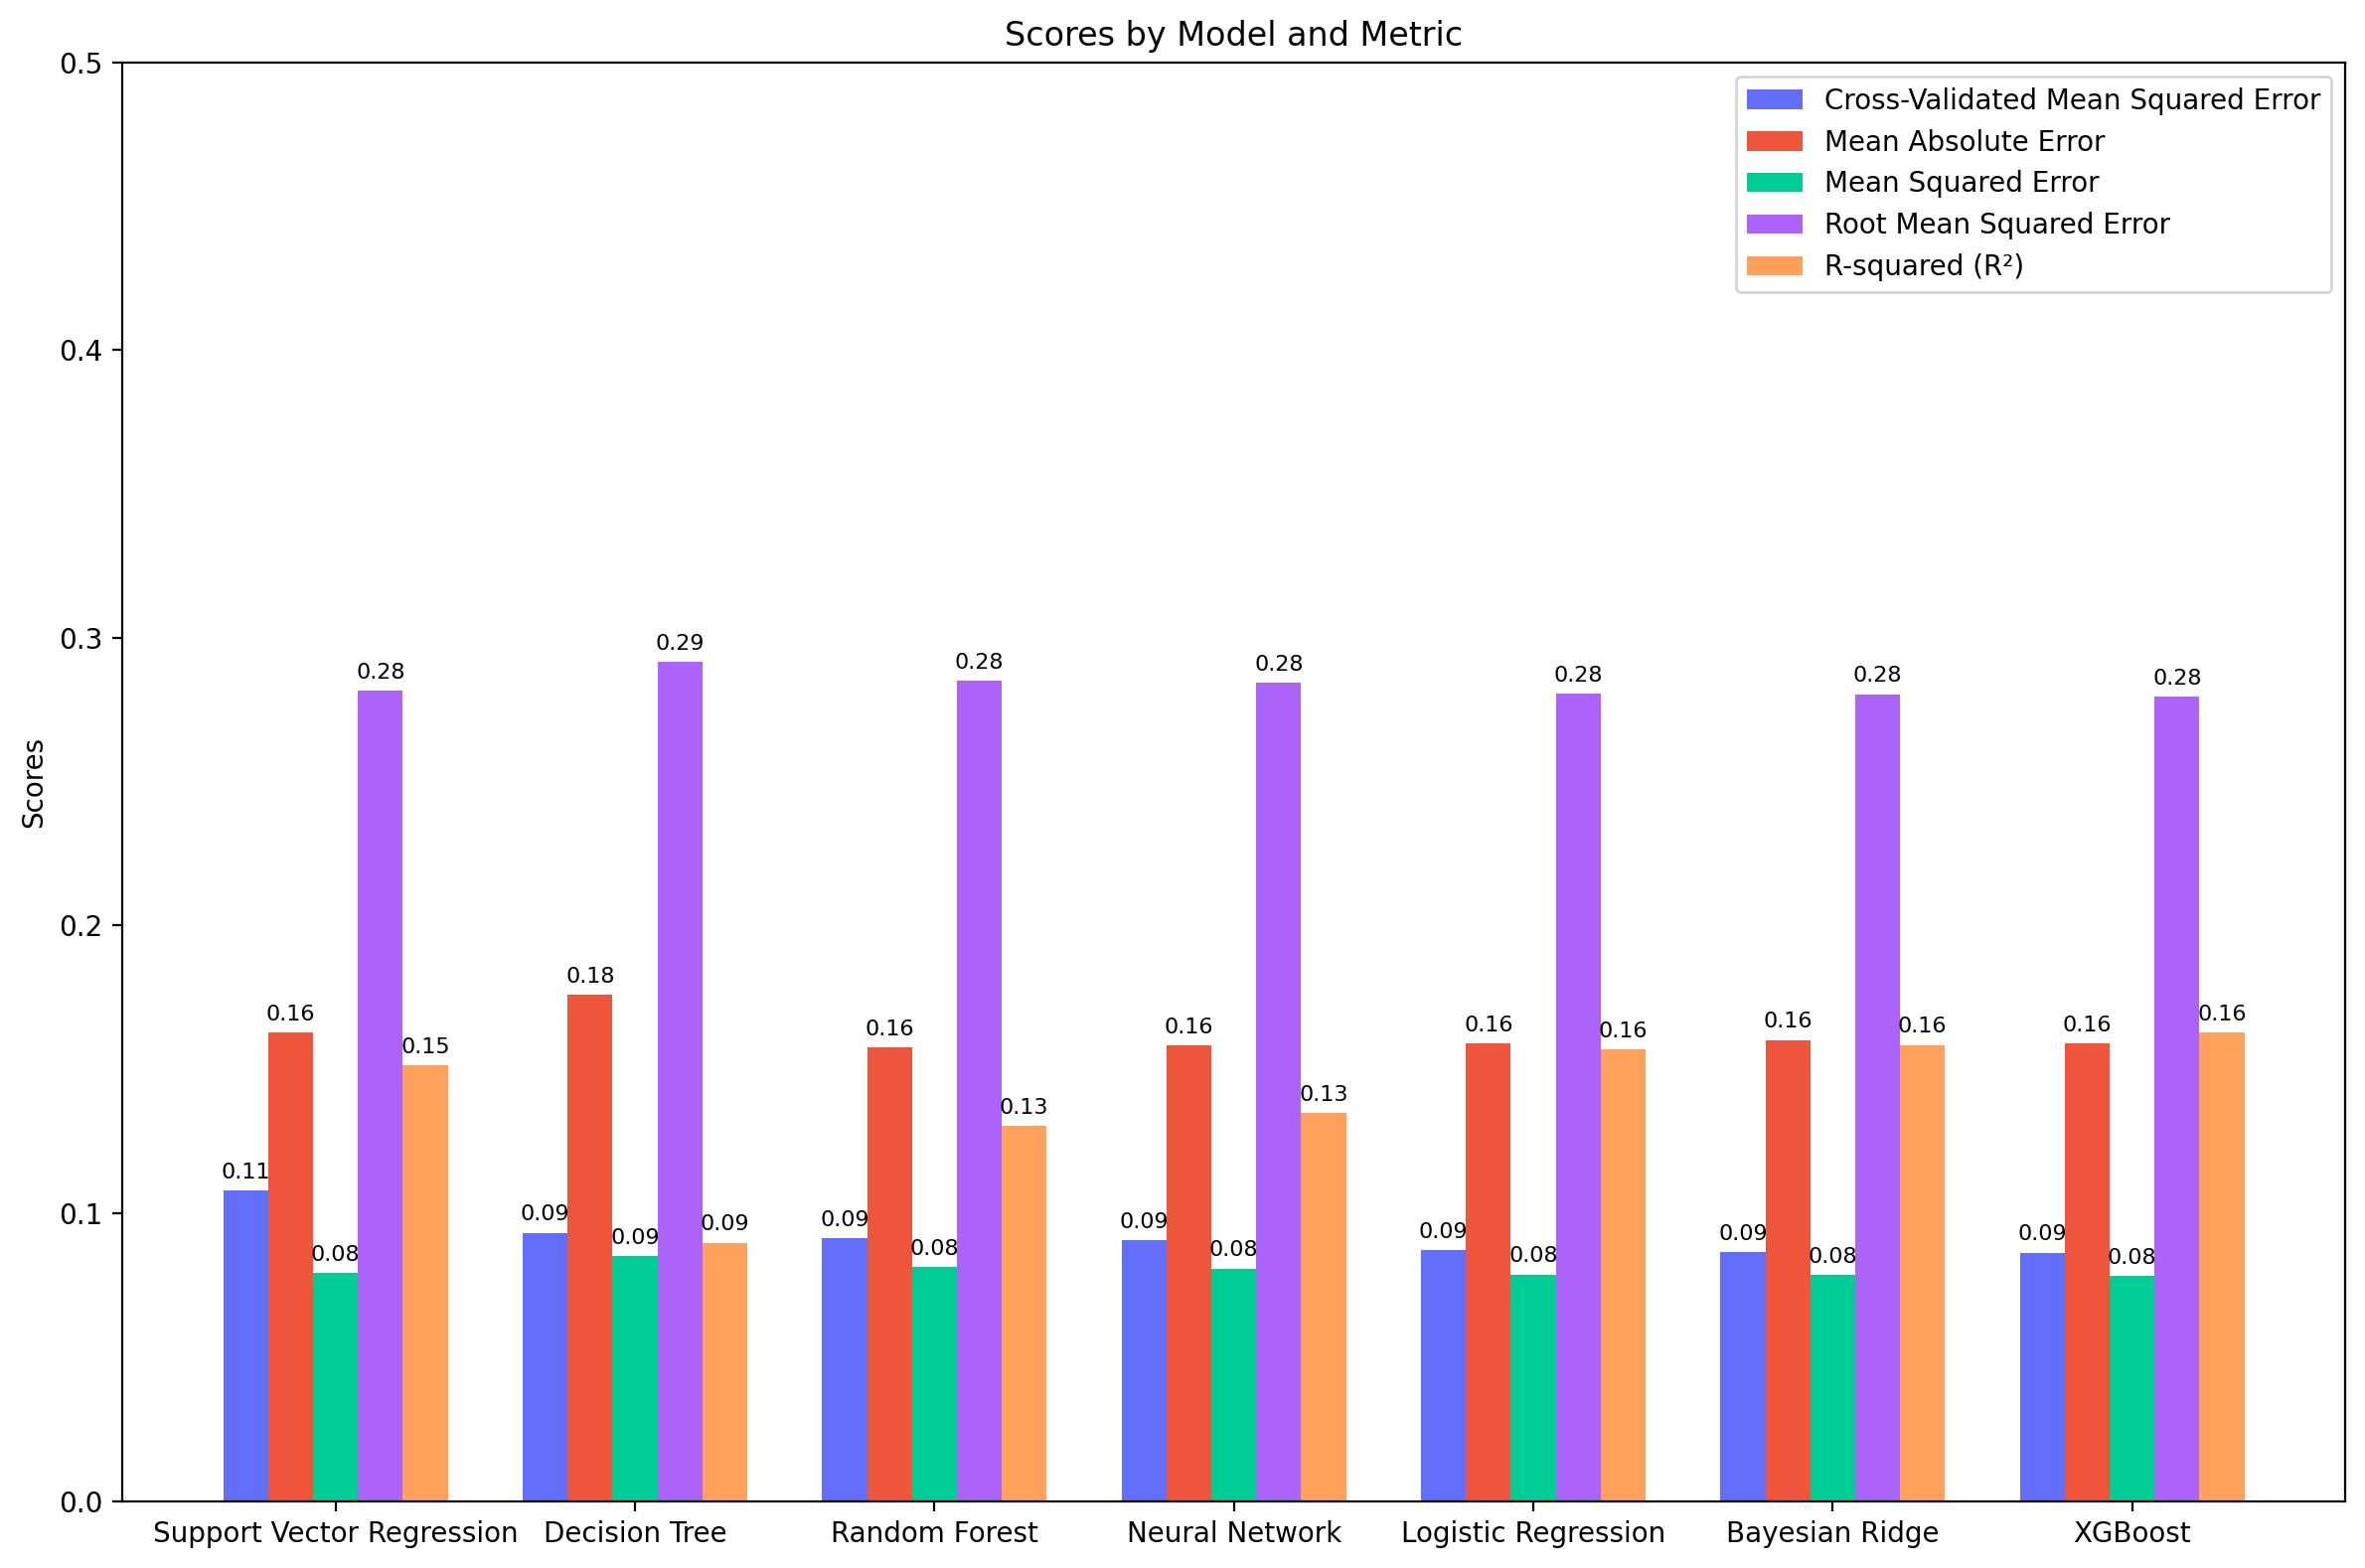

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(types_of_models))  # the label locations
width = 0.15  # the width of the bars

# Use Plotly's qualitative color map
cmap = px.colors.qualitative.Plotly

# Plot each metric with direct color assignment from cmap
rects1 = ax.bar(x - 2 * width, df['Cross-Validated MSE'], width, label='Cross-Validated Mean Squared Error', color=cmap[0])
rects2 = ax.bar(x - width, df['MAE'], width, label='Mean Absolute Error', color=cmap[1])
rects3 = ax.bar(x, df['MSE'], width, label='Mean Squared Error', color=cmap[2])
rects4 = ax.bar(x + width, df['RMSE'], width, label='Root Mean Squared Error', color=cmap[3])
rects5 = ax.bar(x + 2 * width, df['R²'], width, label='R-squared (R²)', color=cmap[4])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(x)
ax.set_xticklabels(types_of_models)
ax.legend()
ax.set_ylim(0, 0.5)

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)
add_labels(rects5)

fig.tight_layout()
#plt.savefig('img_models/model_comparison.png')
plt.show()